### Missing labels classification

This is a small exploratory study on the avaiable methods to solve the missing label classification problem.

In [159]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision as tv
import torchvision.datasets as tvd
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from typing import Union

In [160]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

####  Problem statement

Let's consider the following scenario: an image dataset was processed before using the following transformations. From this we have access only to $30%$ of the labeled data, the others does not have any labels. Predict the test partition using only this restricted info about the data. 

In [181]:
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.1,), (0.9,)),
    transforms.Lambda(lambda x: x.view(-1, 32, 32)), # You can use any operation here
    # grey scale images
    # transforms.Lambda(lambda x: x / 255)
])

In [182]:
dataset = tvd.CIFAR10(root="./data/cifar", download=True, transform=transform)

Files already downloaded and verified


In [183]:
test_dataset = tvd.CIFAR10(root="./data/cifar-test", download=True, transform=transform, train=False)

Files already downloaded and verified


In [184]:
# Reduce the number of points in the train dataset to 3000
train_dataset = torch.utils.data.Subset(dataset, [i for i in range(3000)])
train_dataset[0][0].shape

torch.Size([3, 32, 32])

In [185]:
def show(img: Union[np.ndarray, torch.Tensor], ax: plt.Axes = None, label: int = None):
    if type(img) == torch.Tensor:
        npimg = img.cpu().numpy()
    else:
        npimg = img
    if ax is None:
        ax = plt
    else:
        ax.set_title(f"Label {label}")
    
    ax.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')    

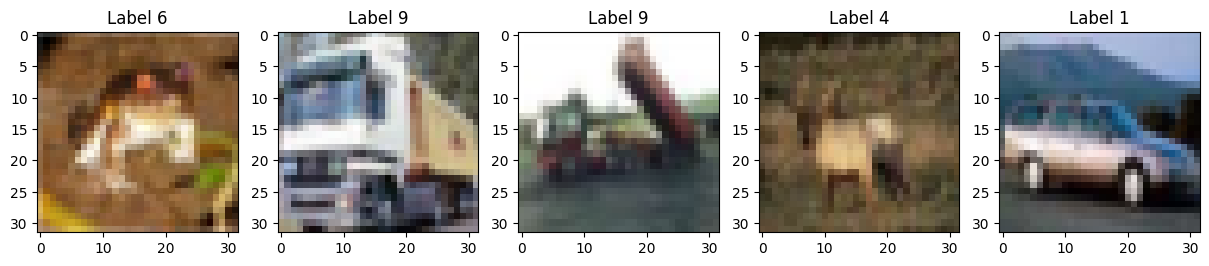

In [186]:
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    show(img=train_dataset[i][0], ax=ax[i], label=train_dataset[i][1])

### Model

In [203]:
model = tv.models.resnet18(weights=tv.models.ResNet18_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False

model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
model.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 1),
    nn.Sigmoid()
)

model = model.to(device)

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
epochs = 10

In [204]:
dl = DataLoader(dataset=train_dataset, shuffle=True, batch_size=8)

In [ ]:
for epoch in range(epochs):
    for idx, data in enumerate(dl):
        imgs, lables = data

        labels = labels.view(-1, 1).float()
        
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        model.train()

        prediction = model(imgs)

        batch_loss = loss_fn(prediction, labels)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        if idx == len(data):
            model.eval()
            prediction = model(imgs)
            is_correct = (prediction == labels)
            accuracy = is_correct.cpu().numpy().sum() / 8

            print(f"Epoch: {epoch} Loss: {batch_loss.item():.4f} Accuracy: {accuracy * 100:.4f}%")

Epoch: 0 Loss: -0.2768 Accuracy: 0.0000%
Epoch: 1 Loss: -237.5000 Accuracy: 12.5000%


In [193]:
test_dl = DataLoader(dataset=test_dataset, shuffle=True, batch_size=32)

In [202]:
accuracies = []
total = 100
for idx, data in enumerate(test_dl):
    imgs, lables = data

    labels = labels.view(-1, 1).float()

    imgs = imgs.to(device)
    labels = labels.to(device)

    model.eval()
    prediction = model(imgs)
    is_correct = (prediction == labels)
    accuracy = is_correct.cpu().numpy().sum() / 32
    accuracies.append(accuracy)
    
    total -= 1
    if total == 0:
        break

accuracies = np.array(accuracies)
accuracy = accuracies.sum() / len(accuracies)
print(f"Accuracy: {accuracy * 100:.4f}%")

Accuracy: 3.1250%


### Data tweaks